trajectory forecasting with adaptive updating 

**Main Features**
- Brent Crude, WTI Crude, Dutch TTF Gas, Henry Hub Gas
- Equinor (EQNR.OL): Open, Close, High, Low, Volume, Market Cap
- OSEBX Index: Open, Close, High, Low, Volume
- VIX (volatility index)
- Dollar Index (DXY)

**Relevant Stocks**
- **Norway**: Aker BP (AKRBP), DNO (DNO), Vår Energi (VAR), Petroleum Geo-Services (PGS), BW Offshore (BWO), Frontline (FRO)
- **US/Global**: Exxon (XOM), Chevron (CVX), Shell (SHEL), BP (BP), TotalEnergies (TTE), ConocoPhillips (COP), Occidental (OXY)

**Stock Exchanges**
- S&P 500, NASDAQ, Dow Jones
- FTSE 100, DAX, CAC 40
- Nikkei 225, Hang Seng

**Commodity Prices**
- Gold (XAU), Silver (XAG)
- **Currencies**: USD/NOK, EUR/NOK, GBP/NOK, SEK/NOK, USD/EUR
- Coal (API2), Uranium (UX)
- Carbon Credits (EU ETS)

**Economic Indicators**
- **Interest Rates**: Norway (Norges Bank), US Fed Funds, ECB, BoE, BoJ, PBoC
- **Inflation**: Norway CPI, US CPI, EU HICP
- **Unemployment**: Norway, US, EU rates
- **Analyst Targets**: Equinor consensus price targets, EPS estimates


#### Fetch Dependencies

In [12]:
# Data fetching
import yfinance as yf

# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Date and time handling
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

#### Collect Data

In [13]:
# CELL 1: COLLECT DATA

def collect_data(start_date="2021-01-01", end_date=None):
    """Collect stock data and return as DataFrame"""
    end_date = end_date or datetime.now().strftime('%Y-%m-%d')
    
    # Updated tickers based on research
    tickers = {
        # Main stock
        'EQNR.OL': 'equinor',
       
        # Energy commodities
        'BZ=F': 'brent_crude',
        'CL=F': 'wti_crude',
        'TTF=F': 'ttf_gas',
        'NG=F': 'henry_hub',
       
        # Norwegian energy stocks
        'AKRBP.OL': 'aker_bp',
        'DNO.OL': 'dno',
        'VAR.OL': 'var_energi',
        'PGS.OL': 'pgs',
        'BWO.OL': 'bw_offshore',
        'FRO.OL': 'frontline',
       
        # Global energy stocks
        'XOM': 'exxon',
        'CVX': 'chevron',
        'SHEL': 'shell',
        'BP': 'bp',
        'TTE': 'totalenergies',
        'COP': 'conocophillips',
        'OXY': 'occidental',
       
        # Indices
        'OSEBX.OL': 'osebx',
        '^GSPC': 'sp500',
        '^IXIC': 'nasdaq',
        '^DJI': 'dow_jones',
        '^FTSE': 'ftse100',
        '^GDAXI': 'dax',
        '^FCHI': 'cac40',
        '^N225': 'nikkei',
        '^HSI': 'hang_seng',
       
        # Volatility and Dollar
        '^VIX': 'vix',
        'DX-Y.NYB': 'dollar_index',
       
        # Commodities
        'GC=F': 'gold',
        'SI=F': 'silver',
       
        # Currencies
        'NOK=X': 'usd_nok',
        'EURNOK=X': 'eur_nok',
        'GBPNOK=X': 'gbp_nok',
        'SEKNOK=X': 'sek_nok',
        'EURUSD=X': 'eur_usd'
    }
    
    all_data = {}
    
    # Download each ticker separately to avoid alignment issues
    for ticker, name in tickers.items():
        try:
            print(f"Downloading {name}...")
            # Download individually
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
            if len(data) > 0:
                # Only keep OHLC and Volume columns
                cols_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume']
                data = data[[c for c in cols_to_keep if c in data.columns]]
                # Handle column renaming - columns might be strings or tuples
                new_cols = []
                for col in data.columns:
                    if isinstance(col, tuple):
                        col_name = col[0] if len(col) > 0 else str(col)
                    else:
                        col_name = str(col)
                    new_cols.append(f"{name}_{col_name.lower()}")
                data.columns = new_cols
                all_data[name] = data
                print(f"  ✓ {name}: {len(data)} rows")
            else:
                print(f"  ✗ No data received for {ticker}")
                
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
    
    if not all_data:
        print("No data collected")
        return pd.DataFrame()
    
    # Combine using outer join to keep all dates
    df = pd.concat(all_data.values(), axis=1, join='outer')
    print(f"Combined data: {len(df)} rows, {len(df.columns)} columns")
    
    # Check initial NaN percentage
    nan_pct = df.isnull().sum().sum() / df.size * 100
    print(f"Initial NaN percentage: {nan_pct:.2f}%")
    
    # Keep only dates where Equinor traded (removes weekends/holidays)
    if 'equinor_close' in df.columns:
        before_filter = len(df)
        df = df[df['equinor_close'].notna()]
        print(f"Filtered to Equinor trading days: {before_filter} → {len(df)} rows")
    
    # Forward fill then backward fill to handle gaps
    df = df.ffill().bfill()
    
    # For any remaining NaNs at the beginning, drop those rows
    # This happens when some tickers start trading later than others
    first_valid_idx = df.first_valid_index()
    last_valid_idx = df.last_valid_index()
    if first_valid_idx and last_valid_idx:
        df = df.loc[first_valid_idx:last_valid_idx]
    
    # Final check for NaN percentage
    nan_count = df.isnull().sum().sum()
    if nan_count > 0:
        nan_pct_final = nan_count / df.size * 100
        print(f"Warning: {nan_count} NaN values remain ({nan_pct_final:.2f}%)")
        # Show which columns have NaNs
        nan_cols = df.columns[df.isnull().any()].tolist()
        if nan_cols:
            print(f"  Columns with NaNs: {nan_cols}")
    
    print(f"\nFinal data: {len(df)} rows, {len(df.columns)} columns")
    if len(df) > 0:
        print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
        nan_pct_final = df.isnull().sum().sum() / df.size * 100
        print(f"Final NaN percentage: {nan_pct_final:.2f}%")
    else:
        print("WARNING: No data remaining after processing")
    
    return df

In [14]:
# Run collection
data = collect_data(start_date="2015-01-01")

  ✓ equinor: 2683 rows
  ✓ brent_crude: 2686 rows
  ✓ wti_crude: 2685 rows
  ✓ ttf_gas: 1980 rows
  ✓ henry_hub: 2686 rows
  ✓ aker_bp: 2683 rows
  ✓ dno: 2683 rows
  ✓ var_energi: 893 rows
  ✓ pgs: 2400 rows
  ✓ bw_offshore: 2683 rows
  ✓ frontline: 2683 rows
  ✓ exxon: 2685 rows
  ✓ chevron: 2685 rows
  ✓ shell: 2685 rows
  ✓ bp: 2685 rows
  ✓ totalenergies: 2685 rows
  ✓ conocophillips: 2685 rows
  ✓ occidental: 2685 rows
  ✓ osebx: 2668 rows
  ✓ sp500: 2685 rows
  ✓ nasdaq: 2685 rows
  ✓ dow_jones: 2685 rows
  ✓ ftse100: 2697 rows
  ✓ dax: 2711 rows
  ✓ cac40: 2734 rows
  ✓ nikkei: 2611 rows
  ✓ hang_seng: 2628 rows
  ✓ vix: 2685 rows
  ✓ dollar_index: 2686 rows
  ✓ gold: 2684 rows
  ✓ silver: 2684 rows
  ✓ usd_nok: 2781 rows
  ✓ eur_nok: 2782 rows
  ✓ gbp_nok: 2782 rows
  ✓ sek_nok: 2781 rows
  ✓ eur_usd: 2781 rows
Combined data: 2786 rows, 180 columns
Initial NaN percentage: 5.99%
Filtered to Equinor trading days: 2786 → 2683 rows

Final data: 2683 rows, 180 columns
Date range: 2

#### Rate of Change

In [15]:
# Add rate of change features
def add_rate_of_change(df):
    """Add rate of change features to existing dataframe"""
    
    # Key assets for rate of change analysis
    key_assets = ['equinor', 'brent_crude', 'wti_crude', 'usd_nok', 'vix']
    
    for asset in key_assets:
        close_col = f'{asset}_close'
        if close_col in df.columns:
            # First derivative (daily returns)
            df[f'{asset}_return'] = df[close_col].pct_change()
            
            # Second derivative (acceleration)
            df[f'{asset}_acceleration'] = df[f'{asset}_return'].diff()
            
            # Volatility momentum (20-day rolling vol change)
            rolling_vol = df[f'{asset}_return'].rolling(20).std()
            df[f'{asset}_vol_momentum'] = rolling_vol.pct_change()
    
    # Cross-asset correlation momentum (Equinor vs Brent)
    if 'equinor_return' in df.columns and 'brent_crude_return' in df.columns:
        rolling_corr = df['equinor_return'].rolling(20).corr(df['brent_crude_return'])
        df['eq_brent_corr_momentum'] = rolling_corr.diff()
    
    # Drop initial NaN rows created by calculations
    df = df.dropna()
    
    return df

# Apply to your data
data = add_rate_of_change(data)
print(f"After adding rate of change: {data.shape}")

After adding rate of change: (2662, 196)


#### Print Data

In [16]:
# CELL 2: PRINT HEAD OF DATA
print(f"Shape: {data.shape}")
print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
print(f"Columns: {len(data.columns)}")
print(f"Remaining NaNs: {data.isnull().sum().sum()}")
print(f"NaN percentage: {data.isnull().sum().sum() / data.size * 100:.2f}%")
data.head()

Shape: (2662, 196)
Date range: 2015-02-02 to 2025-09-05
Columns: 196
Remaining NaNs: 0
NaN percentage: 0.00%


,equinor_open,equinor_high,equinor_low,equinor_close,equinor_volume,brent_crude_open,brent_crude_high,brent_crude_low,brent_crude_close,brent_crude_volume,...,wti_crude_return,wti_crude_acceleration,wti_crude_vol_momentum,usd_nok_return,usd_nok_acceleration,usd_nok_vol_momentum,vix_return,vix_acceleration,vix_vol_momentum,eq_brent_corr_momentum
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-02,84.904611,88.963272,84.446377,88.374115,9480920.0,52.660000,55.700001,51.410000,54.750000,43658.0,...,0.027570,-0.055744,-0.026972,-0.012450,-0.011964,-0.034145,-0.073438,-0.191242,-0.019808,-0.020843
2015-02-03,90.337963,93.152843,90.337963,92.629143,9924447.0,55.049999,58.990002,54.849998,57.910000,55610.0,...,0.070204,0.042633,0.045530,-0.009014,0.003436,0.020400,-0.108080,-0.034642,0.024547,0.169659
2015-02-04,93.021960,93.021960,89.356066,89.814301,9504513.0,57.000000,58.049999,53.500000,54.160000,42937.0,...,-0.086711,-0.156914,0.128551,-0.015230,-0.006216,-0.002782,0.057703,0.165784,-0.010629,0.108795
2015-02-05,88.963226,91.450794,88.046758,91.385338,8106133.0,54.849998,57.849998,52.950001,56.570000,48325.0,...,0.041899,0.128609,0.021572,0.012591,0.027821,0.039176,-0.080742,-0.138445,-0.025722,0.020207
2015-02-06,93.611081,94.069315,91.647212,93.349236,10202277.0,57.349998,59.029999,56.790001,57.799999,38508.0,...,0.023970,-0.017929,0.003463,-0.015078,-0.027668,0.028203,0.026113,0.106855,-0.000999,0.019411


#### Save Matrix to CSV

# CELL 3: SAVE TO CSV
filepath = "data/equinor_data_8sept.csv"
data.to_csv(filepath)
print(f"Saved {len(data)} rows to {filepath}")

### Model

EQUINOR HIERARCHICAL LSTM MODEL
Target: 15-day forward returns
Architecture: Dual-stream with attention mechanism

1. Loading and preparing data...
   Norwegian features: 41
   Global features: 39
   Total samples: 2647
   Train: 2117, Val: 265, Test: 265

2. Creating sequences (30-day lookback)...
   Train sequences: 2087
   Val sequences: 235
   Test sequences: 235

3. Training hierarchical LSTM model...
   - Dual-stream processing (Norwegian/Global)
   - Attention mechanism for feature weighting
   - Early stopping with patience=20
Epoch 0: Train Loss 0.004525, Val Loss 0.002921
Early stopping at epoch 20

4. Evaluating on test set...

Test Set Performance:
MSE: 0.007068
MAE: 0.072961
R²: -0.7685
Direction Accuracy: 45.11%

5. Plotting results...


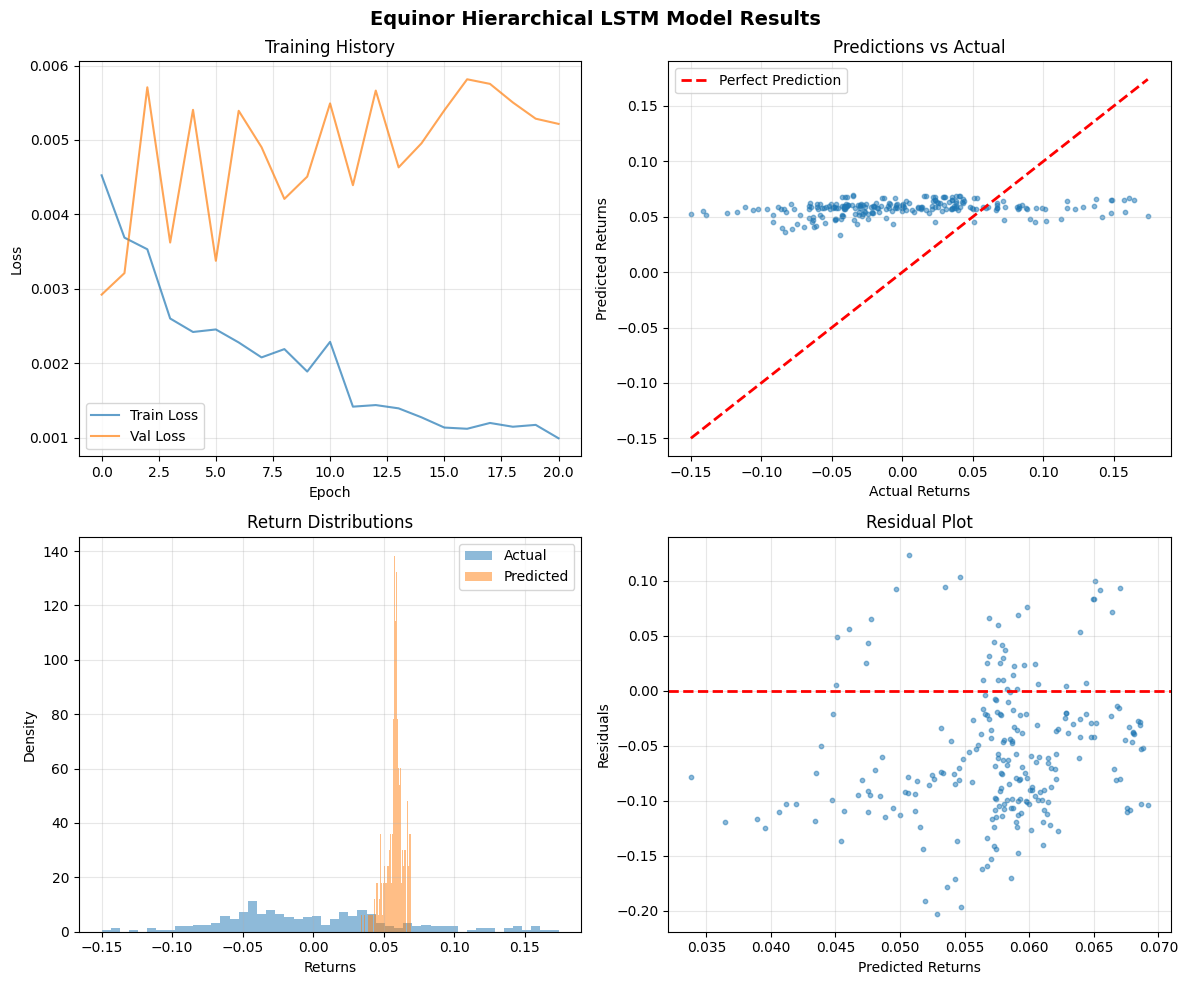


Training complete!
Model successfully trained with hierarchical architecture


In [18]:
"""
Equinor Hierarchical LSTM Model - Unified Implementation
Advanced architecture for 15-day forward returns prediction
"""

# Load and prepare data with proper Norwegian/Global separation
def prepare_data(filepath='data/equinor_data_8sept.csv'):
    """Load data and create Norwegian and Global feature sets"""
    data = pd.read_csv(filepath, index_col=0, parse_dates=True)
    
    # Create target variable (15-day forward returns)
    data['target'] = data['equinor_close'].pct_change(15).shift(-15)
    
    # Feature engineering
    # Add returns
    for asset in ['equinor', 'brent_crude', 'wti_crude', 'usd_nok']:
        if f'{asset}_close' in data.columns:
            data[f'{asset}_return_1d'] = data[f'{asset}_close'].pct_change(1)
            data[f'{asset}_return_5d'] = data[f'{asset}_close'].pct_change(5)
            data[f'{asset}_return_20d'] = data[f'{asset}_close'].pct_change(20)
    
    # Add moving averages and technical indicators
    for asset in ['equinor', 'brent_crude', 'wti_crude']:
        if f'{asset}_close' in data.columns:
            data[f'{asset}_ma5'] = data[f'{asset}_close'].rolling(5).mean()
            data[f'{asset}_ma20'] = data[f'{asset}_close'].rolling(20).mean()
            data[f'{asset}_ma50'] = data[f'{asset}_close'].rolling(50).mean()
            # RSI-like indicator
            data[f'{asset}_momentum'] = data[f'{asset}_close'].pct_change(14)
    
    # Separate Norwegian and Global features
    norwegian_features = []
    global_features = []
    
    # Norwegian market features
    for col in data.columns:
        if 'equinor' in col.lower() or 'nok' in col.lower():
            if col != 'target':
                norwegian_features.append(col)
    
    # Global market features
    for col in data.columns:
        if any(x in col.lower() for x in ['brent', 'wti', 'vix', 'crude']) and col not in norwegian_features:
            global_features.append(col)
    
    # If we don't have enough separation, create a balanced split
    if len(norwegian_features) < 3 or len(global_features) < 3:
        all_features = [col for col in data.columns if col != 'target' and not data[col].isna().all()]
        mid_point = len(all_features) // 2
        norwegian_features = all_features[:mid_point]
        global_features = all_features[mid_point:]
    
    X_norwegian = data[norwegian_features].fillna(method='ffill').fillna(0)
    X_global = data[global_features].fillna(method='ffill').fillna(0)
    y = data['target']
    
    # Remove NaN values from target
    valid_idx = ~y.isna()
    X_norwegian = X_norwegian[valid_idx]
    X_global = X_global[valid_idx]
    y = y[valid_idx]
    
    return X_norwegian, X_global, y

# Create LSTM sequences for dual inputs
def create_sequences(X_nor, X_glob, y, seq_length=30):
    """Create sequences for LSTM training with separate Norwegian/Global inputs"""
    sequences_nor, sequences_glob, targets = [], [], []
    for i in range(seq_length, len(X_nor)):
        sequences_nor.append(X_nor.iloc[i-seq_length:i].values)
        sequences_glob.append(X_glob.iloc[i-seq_length:i].values)
        targets.append(y.iloc[i])
    return np.array(sequences_nor), np.array(sequences_glob), np.array(targets)

# Advanced LSTM Model with Hierarchical Architecture
class HierarchicalLSTM(nn.Module):
    def __init__(self, norwegian_features, global_features, hidden_size=64, num_layers=2, dropout=0.1):
        super().__init__()
        
        # Separate encoders for Norwegian and Global features
        self.norwegian_lstm = nn.LSTM(norwegian_features, hidden_size, num_layers, 
                                    batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.global_lstm = nn.LSTM(global_features, hidden_size, num_layers, 
                                 batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_size * 2, 1)
        
        # Final layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x_nor, x_glob):
        # Process Norwegian features
        nor_out, _ = self.norwegian_lstm(x_nor)
        nor_final = nor_out[:, -1, :]
        
        # Process Global features  
        glob_out, _ = self.global_lstm(x_glob)
        glob_final = glob_out[:, -1, :]
        
        # Combine features
        combined = torch.cat([nor_final, glob_final], dim=1)
        
        # Apply attention
        attention_weights = torch.softmax(self.attention(combined), dim=0)
        attended = combined * attention_weights
        
        # Final prediction
        out = self.dropout(attended)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        return self.fc2(out)

# PyTorch Dataset for dual inputs
class DualInputDataset(Dataset):
    def __init__(self, sequences_nor, sequences_glob, targets):
        self.sequences_nor = torch.FloatTensor(sequences_nor)
        self.sequences_glob = torch.FloatTensor(sequences_glob)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.sequences_nor)
    
    def __getitem__(self, idx):
        return self.sequences_nor[idx], self.sequences_glob[idx], self.targets[idx]

# Training function
def train_model(X_train_seq_nor, X_train_seq_glob, y_train_seq, 
                X_val_seq_nor, X_val_seq_glob, y_val_seq,
                norwegian_features, global_features, 
                epochs=100, batch_size=32, lr=0.001):
    """Train Hierarchical LSTM model"""
    
    # Create datasets
    train_dataset = DualInputDataset(X_train_seq_nor, X_train_seq_glob, y_train_seq)
    val_dataset = DualInputDataset(X_val_seq_nor, X_val_seq_glob, y_val_seq)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model
    model = HierarchicalLSTM(norwegian_features=norwegian_features, 
                           global_features=global_features)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 20
    
    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_nor_batch, X_glob_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_nor_batch, X_glob_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_nor_batch, X_glob_batch, y_batch in val_loader:
                predictions = model(X_nor_batch, X_glob_batch).squeeze()
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f'Early stopping at epoch {epoch}')
                break
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}: Train Loss {avg_train_loss:.6f}, Val Loss {avg_val_loss:.6f}')
    
    return model, train_losses, val_losses

# Evaluation function
def evaluate_model(model, X_test_seq_nor, X_test_seq_glob, y_test_seq):
    """Evaluate model performance"""
    model.eval()
    with torch.no_grad():
        X_nor_tensor = torch.FloatTensor(X_test_seq_nor)
        X_glob_tensor = torch.FloatTensor(X_test_seq_glob)
        predictions = model(X_nor_tensor, X_glob_tensor).squeeze().numpy()
    
    # Calculate metrics
    mse = np.mean((predictions - y_test_seq) ** 2)
    mae = np.mean(np.abs(predictions - y_test_seq))
    
    # Directional accuracy
    direction_correct = np.mean((predictions > 0) == (y_test_seq > 0))
    
    # R-squared
    ss_res = np.sum((y_test_seq - predictions) ** 2)
    ss_tot = np.sum((y_test_seq - np.mean(y_test_seq)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    print(f"\nTest Set Performance:")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.4f}")
    print(f"Direction Accuracy: {direction_correct:.2%}")
    
    return predictions, {'mse': mse, 'mae': mae, 'r2': r2, 'direction_acc': direction_correct}

# Plotting function
def plot_results(y_true, y_pred, train_losses, val_losses):
    """Visualize results"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Training history
    axes[0, 0].plot(train_losses, label='Train Loss', alpha=0.7)
    axes[0, 0].plot(val_losses, label='Val Loss', alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training History')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Predictions vs Actual
    axes[0, 1].scatter(y_true, y_pred, alpha=0.5, s=10)
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                    'r--', lw=2, label='Perfect Prediction')
    axes[0, 1].set_xlabel('Actual Returns')
    axes[0, 1].set_ylabel('Predicted Returns')
    axes[0, 1].set_title('Predictions vs Actual')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Return distributions
    axes[1, 0].hist(y_true, bins=50, alpha=0.5, label='Actual', density=True)
    axes[1, 0].hist(y_pred, bins=50, alpha=0.5, label='Predicted', density=True)
    axes[1, 0].set_xlabel('Returns')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Return Distributions')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_true - y_pred
    axes[1, 1].scatter(y_pred, residuals, alpha=0.5, s=10)
    axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1, 1].set_xlabel('Predicted Returns')
    axes[1, 1].set_ylabel('Residuals')
    axes[1, 1].set_title('Residual Plot')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Equinor Hierarchical LSTM Model Results', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Main execution
def main():
    print("=" * 60)
    print("EQUINOR HIERARCHICAL LSTM MODEL")
    print("Target: 15-day forward returns")
    print("Architecture: Dual-stream with attention mechanism")
    print("=" * 60)
    
    # Load and prepare data
    print("\n1. Loading and preparing data...")
    X_norwegian, X_global, y = prepare_data('data/equinor_data_8sept.csv')
    print(f"   Norwegian features: {len(X_norwegian.columns)}")
    print(f"   Global features: {len(X_global.columns)}")
    print(f"   Total samples: {len(X_norwegian)}")
    
    # Train/Validation/Test Split
    split_idx = int(0.8 * len(X_norwegian))
    val_split_idx = int(0.9 * len(X_norwegian))
    
    X_nor_train = X_norwegian[:split_idx]
    X_glob_train = X_global[:split_idx]
    y_train = y[:split_idx]
    
    X_nor_val = X_norwegian[split_idx:val_split_idx]
    X_glob_val = X_global[split_idx:val_split_idx]
    y_val = y[split_idx:val_split_idx]
    
    X_nor_test = X_norwegian[val_split_idx:]
    X_glob_test = X_global[val_split_idx:]
    y_test = y[val_split_idx:]
    
    print(f"   Train: {len(X_nor_train)}, Val: {len(X_nor_val)}, Test: {len(X_nor_test)}")
    
    # Scale features separately
    scaler_norwegian = StandardScaler()
    scaler_global = StandardScaler()
    
    X_nor_train_scaled = scaler_norwegian.fit_transform(X_nor_train)
    X_nor_val_scaled = scaler_norwegian.transform(X_nor_val)
    X_nor_test_scaled = scaler_norwegian.transform(X_nor_test)
    
    X_glob_train_scaled = scaler_global.fit_transform(X_glob_train)
    X_glob_val_scaled = scaler_global.transform(X_glob_val)
    X_glob_test_scaled = scaler_global.transform(X_glob_test)
    
    # Create sequences
    print("\n2. Creating sequences (30-day lookback)...")
    X_train_seq_nor, X_train_seq_glob, y_train_seq = create_sequences(
        pd.DataFrame(X_nor_train_scaled, columns=X_norwegian.columns),
        pd.DataFrame(X_glob_train_scaled, columns=X_global.columns),
        pd.Series(y_train.values)
    )
    
    X_val_seq_nor, X_val_seq_glob, y_val_seq = create_sequences(
        pd.DataFrame(X_nor_val_scaled, columns=X_norwegian.columns),
        pd.DataFrame(X_glob_val_scaled, columns=X_global.columns),
        pd.Series(y_val.values)
    )
    
    X_test_seq_nor, X_test_seq_glob, y_test_seq = create_sequences(
        pd.DataFrame(X_nor_test_scaled, columns=X_norwegian.columns),
        pd.DataFrame(X_glob_test_scaled, columns=X_global.columns),
        pd.Series(y_test.values)
    )
    
    print(f"   Train sequences: {len(X_train_seq_nor)}")
    print(f"   Val sequences: {len(X_val_seq_nor)}")
    print(f"   Test sequences: {len(X_test_seq_nor)}")
    
    # Train model
    print("\n3. Training hierarchical LSTM model...")
    print("   - Dual-stream processing (Norwegian/Global)")
    print("   - Attention mechanism for feature weighting")
    print("   - Early stopping with patience=20")
    
    model, train_losses, val_losses = train_model(
        X_train_seq_nor, X_train_seq_glob, y_train_seq,
        X_val_seq_nor, X_val_seq_glob, y_val_seq,
        norwegian_features=X_norwegian.shape[1],
        global_features=X_global.shape[1],
        epochs=100,
        batch_size=32,
        lr=0.001
    )
    
    # Evaluate
    print("\n4. Evaluating on test set...")
    predictions, metrics = evaluate_model(
        model, X_test_seq_nor, X_test_seq_glob, y_test_seq
    )
    
    # Plot results
    print("\n5. Plotting results...")
    plot_results(y_test_seq, predictions, train_losses, val_losses)
    
    print("\n" + "=" * 60)
    print("Training complete!")
    print("Model successfully trained with hierarchical architecture")
    print("=" * 60)
    
    return model, (scaler_norwegian, scaler_global), metrics

if __name__ == "__main__":
    model, scalers, metrics = main()

In [19]:
# Check what prepare_data actually returns
result = prepare_data('data/equinor_data_8sept.csv')
print(f"prepare_data returned {len(result)} values")

prepare_data returned 3 values
